<a href="https://colab.research.google.com/github/ArjunNarendra/455finalproject/blob/main/Machine_Learning_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Model Training

We train different models on the EMNIST dataset and see which one performs best.


## Inital Setup

We download the EMNIST dataset and define our training and accuracy functions.

In [ ]:
import cv2



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torchvision
import torchvision.transforms as transforms

def get_emnist_data():
  # Need to perform a rotate and flip to properly orient the images
  trainset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=True, download=True,
                                        transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor()]))
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=False, download=True,
                                      transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor()]))
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(62)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_emnist_data()

In [ ]:
print(data['train'].__dict__)

{'dataset': Dataset EMNIST
    Number of datapoints: 697932
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               <function get_emnist_data.<locals>.<lambda> at 0x7fd58d78c430>
               <function get_emnist_data.<locals>.<lambda> at 0x7fd58d78c5e0>
               ToTensor()
           ), 'num_workers': 8, 'prefetch_factor': 2, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 32, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x7fd58e051f10>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7fd58d77dd90>, 'generator': None, 'collate_fn': <function default_collate at 0x7fd619793160>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


In [ ]:
print(data['test'].__dict__)

{'dataset': Dataset EMNIST
    Number of datapoints: 116323
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               <function get_emnist_data.<locals>.<lambda> at 0x7fd598e29160>
               <function get_emnist_data.<locals>.<lambda> at 0x7fd59f203af0>
               ToTensor()
           ), 'num_workers': 8, 'prefetch_factor': 2, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 32, 'drop_last': False, 'sampler': <torch.utils.data.sampler.SequentialSampler object at 0x7fd58d796190>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7fd58d7961f0>, 'generator': None, 'collate_fn': <function default_collate at 0x7fd619793160>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


In [ ]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
print(images.size())

torch.Size([32, 1, 28, 28])


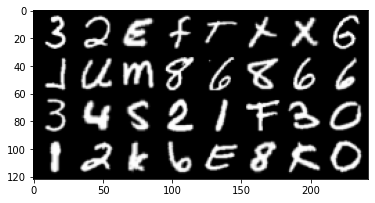

Labels:        3         2        14        41        29        59        59        16
torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % data['classes'][labels[j]] for j in range(8)))


flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [ ]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0005, verbose=1):
  
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward propogate, backward propogate, and update weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in negative gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

RuntimeError: ignored

## Neural Network 1

This network has one hidden layer. The training accuracy was 82.69% and the testing accuracy was 82.39%.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Neural network 1: Simple neural network with one hidden layer
class Net1(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=62):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = F.relu(x)   
        x = self.fc2(x) 
        return x      

In [ ]:
# Train Net1 with default hyperparameters
net = Net1()
losses = train(net, data['train'], epochs=5)
plt.plot(losses)

RuntimeError: ignored

In [ ]:
print("Net1 train accuracy: %f" % accuracy(net, data['train']))

In [ ]:
print("Net1 test accuracy: %f" % accuracy(net, data['test']))

Current test accuracy: 0.823861


We tried varying the learning rate of Net1, but this did not seem to have any significant effect on the model's accuracy

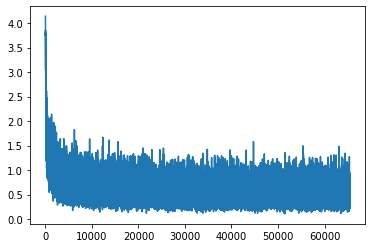

In [ ]:
# Train Net1 with learning rate = 0.1
net = Net1()
losses = train(net, data['train'], epochs=3)
plt.plot(losses)

In [ ]:
print("Net1 train accuracy: %f" % accuracy(net, data['train']))

Net1 train accuracy: 0.828473


In [ ]:
print("Net1 test accuracy: %f" % accuracy(net, data['test']))

## Neural Network 2

This network has two hidden layers. The training accuracy was 83.27% and the testing accuracy was 82.97%.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Neural network 2: Simple neural network with two hidden layers
class Net2(nn.Module):
    def __init__(self, inputs=28*28, hidden1=128, hidden2=128, outputs=62):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)  
        x = self.fc2(x)
        x = F.relu(x) 
        x = self.fc3(x)
        return x      

In [ ]:
# Train Net2 with default hyperparameters
net2 = Net2()
losses = train(net2, data['train'], epochs=5)
plt.plot(losses)

RuntimeError: ignored

In [ ]:
print("Net2 train accuracy: %f" % accuracy(net2, data['train']))

Net2 train accuracy: 0.832724


In [ ]:
print("Net2 test accuracy: %f" % accuracy(net2, data['test']))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Net2 test accuracy: 0.829655


## Neural Network 3

This network has two convolutional layers. The training accuracy was 83.51% and the testing accuracy was 83.13%. When simulated annealing was applied, the training accuracy ticked up 84.28% and the testing accuracy ticked up to 83.75%.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Neural network 3: Convolutional neural network with two convolutional layers
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Input 28x28x1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 14x14x16
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)

        # Input 14x14x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 7x7x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)

        self.fc1 = nn.Linear(1568, 62)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
# Train ConvNet with default hyperparameters
conv_net = ConvNet()
losses = train(conv_net, data['train'], epochs=5)
plt.plot(losses)

In [ ]:
print("ConvNet train accuracy: %f" % accuracy(conv_net, data['train']))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ConvNet train accuracy: 0.835134


In [ ]:
print("ConvNet test accuracy: %f" % accuracy(conv_net, data['test']))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ConvNet test accuracy: 0.831340


We used simulated annealing on ConvNet. This was our best model and the model we used for CAPTCHAs. The training accuracy was 84.28% and the testing accuracy was 83.75%.

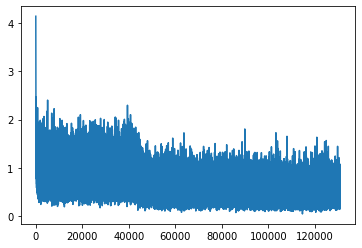

In [ ]:
# Use simulated annealing for training ConvNet
anneal_net = ConvNet()

anneal_losses =  train(anneal_net, data['train'], epochs=2, lr=.1)
anneal_losses += train(anneal_net, data['train'], epochs=2, lr=.01)
anneal_losses += train(anneal_net, data['train'], epochs=2, lr=.001)

plt.plot(anneal_losses)

In [ ]:
print("AnnealNet train accuracy: %f" % accuracy(anneal_net, data['train']))

AnnealNet train accuracy: 0.842833


In [ ]:
print("AnnealNet test accuracy: %f" % accuracy(anneal_net, data['test']))

AnnealNet test accuracy: 0.837496


## Neural Network 4

This network has two convolutional layers with batch normalization. The training accuracy was 83.07% and the testing accuracy was 82.60%.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Neural network 4: Convolutional neural network with two convolutional layers and batch normalization
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(1568, 62)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
# Train ConvBNNet with default hyperparameters
norm_net = ConvBNNet()
norm_losses = train(norm_net, data['train'], epochs=3)
plt.plot(norm_losses)

In [ ]:
print("ConvBNNet train accuracy: %f" % accuracy(norm_net, data['train']))

ConvBNNet train accuracy: 0.830665


In [ ]:
print("ConvBNNet test accuracy: %f" % accuracy(norm_net, data['test']))

ConvBNNet test accuracy: 0.826036
